In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
%matplotlib inline

In [4]:
df = pd.read_csv("data\labeled_data.csv")
df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


##### label 
0 - hate speech
1 - offensive  language
2 - neither

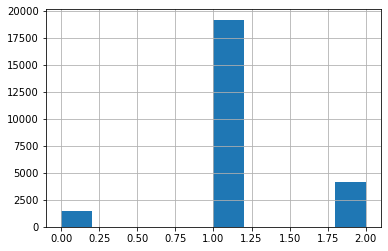

In [5]:
df['class'].hist()

##### i will try to balance my data

In [6]:
df = df.rename(index=str, columns={"class": "label", "tweet": "tweet"})
df.head()

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
X = df.tweet
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
print(Y)
Y = to_categorical(Y)
#Y = Y.reshape(-1,1)
print(Y)

[2 1 1 ... 1 1 2]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


##### spliting data Train / Test  85:15

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


In [10]:
max_words = 1000
max_len = 260
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Defining Model

In [9]:
def RNN(inputs):
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [10]:
model = RNN(sequences_matrix)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 260)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 260, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 771   

C:\Users\3alaa\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
class_weight = {0: 50.,
                1: 1.,
                2: 20.}

In [12]:
b=model.fit(sequences_matrix,Y_train,batch_size=128,epochs=30, class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
165/165 [==============================] - 50s 291ms/step - loss: 5.6172 - accuracy: 0.2862
Epoch 2/30
165/165 [==============================] - 46s 280ms/step - loss: 2.9500 - accuracy: 0.5616
Epoch 3/30
165/165 [==============================] - 46s 281ms/step - loss: 2.3177 - accuracy: 0.6727
Epoch 4/30
165/165 [==============================] - 46s 280ms/step - loss: 2.1137 - accuracy: 0.6749
Epoch 5/30
165/165 [==============================] - 46s 279ms/step - loss: 1.8547 - accuracy: 0.7035
Epoch 6/30
165/165 [==============================] - 47s 282ms/step - loss: 1.7237 - accuracy: 0.7101
Epoch 7/30
165/165 [==============================] - 46s 282ms/step - loss: 1.4570 - accuracy: 0.7291
Epoch 8/30
165/165 [==============================] - 47s 283ms/step - loss: 1.3372 - accuracy: 0.7502
Epoch 9/30
165/165 [==================

#### APPLYING MODEL IN TESTING

In [14]:
#tok = Tokenizer(num_words=max_words)
#tok.fit_on_texts(X_test)
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [15]:
accr = model.evaluate(test_sequences_matrix,Y_test)


117/117 [==============================] - 6s 42ms/step - loss: 0.9433 - accuracy: 0.7735


In [16]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


Test set
  Loss: 0.943
  Accuracy: 0.774


In [17]:
y_preds = model.predict(test_sequences_matrix)


In [19]:
Y_t = []
for i in Y_test:
  Y_t.append(np.argmax(i))
  
#print(Y_t)


Y_p = []

for i in y_preds:
  Y_p.append(np.argmax(i))
  
#print(Y_p)

In [22]:
report = classification_report( Y_t, Y_p )
print(report)

              precision    recall  f1-score   support

           0       0.20      0.66      0.30       214
           1       0.98      0.75      0.85      2908
           2       0.73      0.92      0.81       596

    accuracy                           0.77      3718
   macro avg       0.63      0.78      0.65      3718
weighted avg       0.89      0.77      0.81      3718



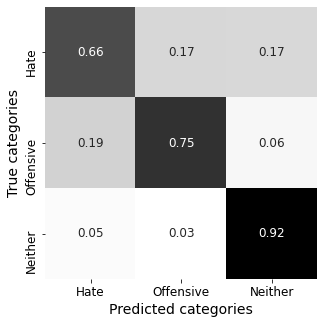

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_t,Y_p)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [48]:
test=pd.read_csv(r"C:\Users\3alaa\Desktop\Untitled Folder\data\reddit.csv")
#test=test.drop(columns=['0','1467810369','NO_QUERY','_TheSpecialOne_','Mon Apr 06 22:19:45 PDT 2009'])
#test=test.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D":"text"})

In [50]:
test=test.drop(columns=['id','hate_speech_idx','response'])

In [95]:
data={'text':['']}
test=pd.DataFrame(data)

In [96]:
r=test.head(20)

In [97]:
b=r["text"]

In [98]:
ts = tok.texts_to_sequences(b)
tss = sequence.pad_sequences(ts,maxlen=max_len)
pred=model.predict(tss)
Y_t = []
for i in pred:
  Y_t.append(np.argmax(i))
  
print(Y_t)

[1]
